In [1]:
%reset
import sys, os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = '0.9'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2




/tmp/ipykernel_3707473/730897873.py:7: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [85]:
# cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 2.0
sim_params_dict['delta_rhogas'] = 7.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.1
sim_params_dict['log10_Mstar0_theta_co'] = 14.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 4.0
sim_params_dict['log10_Mstar0_theta_ej'] = 14.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.0

sim_params_dict['log10_Mc0'] = 14.83
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = 0.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 12, 48
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
# halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 3.0, 24
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
# halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 11.0, 16.0, 48
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 8, 16
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.05
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 5
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
nz_info_dict['nz4'] = np.maximum(df['nz_source'].data['BIN5'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits')
theta_data = df_data['xip'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.0
analysis_dict['want_like_diff'] = False
analysis_dict['calc_nfw_only'] = True

other_params_dict = {}
other_params_dict['A_IA'] = 0.0
other_params_dict['eta_IA'] = 0.0
other_params_dict['z0_IA'] = 0.62
other_params_dict['C1_bar'] = 0.0134
other_params_dict['Delta_z_bias_array'] = np.zeros(nz_info_dict['nbins'])
other_params_dict['mult_shear_bias_array'] = np.zeros(nz_info_dict['nbins'])



In [24]:
# # cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
# cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
# sim_params_dict = {}
# sim_params_dict['nfw_trunc'] = True
# sim_params_dict['gamma_rhogas'] = 2.0
# sim_params_dict['delta_rhogas'] = 7.0
# # sim_params_dict['theta_co'] = 0.01
# # sim_params_dict['theta_ej'] = 1.0

# sim_params_dict['theta_co_0'] = 0.1
# sim_params_dict['log10_Mstar0_theta_co'] = 14.0
# sim_params_dict['nu_theta_co_M'] = 0.05
# sim_params_dict['nu_theta_co_z'] = 0.0

# sim_params_dict['theta_ej_0'] = 4.4315
# sim_params_dict['log10_Mstar0_theta_ej'] = 14.0
# sim_params_dict['nu_theta_ej_M'] = 0.05
# sim_params_dict['nu_theta_ej_z'] = 0.05

# sim_params_dict['log10_Mc0'] = 14.83
# sim_params_dict['log10_Mstar0'] = 14.0
# sim_params_dict['mu_beta'] = 0.21
# sim_params_dict['nu_z'] = -2.5
# sim_params_dict['nu_M'] = 0.0

# sim_params_dict['eta_star'] = 0.3
# sim_params_dict['eta_cga'] = 0.6


# sim_params_dict['neg_bhse_plus_1'] = 0.833
# sim_params_dict['A_starcga'] = 0.09
# sim_params_dict['log10_M1_starcga'] = 11.4
# sim_params_dict['epsilon_rt'] = 4.0


# sim_params_dict['a_zeta'] = 0.3
# sim_params_dict['n_zeta'] = 2
# sim_params_dict['alpha_nt'] = 0.18
# sim_params_dict['beta_nt'] = 0.5
# sim_params_dict['n_nt'] = 0.3
# sim_params_dict['cosmo'] = cosmo_params_dict


# halo_params_dict = {}
# halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 12, 48
# # halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# # halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
# # halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 3.0, 24
# # halo_params_dict['z_array'] = np.array([1e-3])
# # halo_params_dict['z_array'] = np.array([0.5])
# # halo_params_dict['z_array'] = np.array([1.0])
# # halo_params_dict['nz'] = len(halo_params_dict['z_array'])
# halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 11.5, 15.5, 32
# halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 8, 16
# halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# # try:
# halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.05
# halo_params_dict['mdef'] = '200c'
# halo_params_dict['hmf_model'] = 'T10'
# halo_params_dict['conc_model'] = 'Diemer15'
# halo_params_dict['do_corr_2h_mm'] = True

# # halo_params_dict['do_corr_2h_mm'] = False

# from astropy.io import fits
# df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits') 
# z_array = df['nz_source'].data['Z_MID']
# nz_info_dict = {}
# nz_info_dict['z_array'] = z_array
# nz_info_dict['nbins'] = 5
# nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
# nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
# nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
# nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
# nz_info_dict['nz4'] = np.maximum(df['nz_source'].data['BIN5'], 1e-4)
# analysis_dict = {}
# analysis_dict['nz_info_dict'] = nz_info_dict
# analysis_dict['do_sheary'] = True
# analysis_dict['do_shear2pt'] = True
# analysis_dict['do_yy'] = False

# df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits')
# theta_data = df_data['xip'].data['ANG'][0:20]

# analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
# # analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 128
# analysis_dict['angles_data_array'] = jnp.array(theta_data)
# analysis_dict['beam_fwhm_arcmin'] = 1.0
# analysis_dict['want_like_diff'] = True
# analysis_dict['calc_nfw_only'] = True

# other_params_dict = {}
# other_params_dict['A_IA'] = 0.1
# other_params_dict['eta_IA'] = 0.0
# other_params_dict['z0_IA'] = 0.62
# other_params_dict['C1_bar'] = 5e-14
# # for jb in range(nz_info_dict['nbins']):
# #     other_params_dict['Delta_z_bias_bin%d'%(jb+1)] = 0.0
# #     other_params_dict['mult_shear_bias_bin%d'%(jb+1)] = 0.0
# other_params_dict['Delta_z_bias_array'] = jnp.zeros(nz_info_dict['nbins'])
# other_params_dict['mult_shear_bias_array'] = jnp.zeros(nz_info_dict['nbins'])



In [20]:
# # cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
# cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
# sim_params_dict = {}
# sim_params_dict['nfw_trunc'] = True
# sim_params_dict['gamma_rhogas'] = 2.0
# sim_params_dict['delta_rhogas'] = 7.0
# # sim_params_dict['theta_co'] = 0.01
# # sim_params_dict['theta_ej'] = 1.0

# sim_params_dict['theta_co_0'] = 0.1
# sim_params_dict['log10_Mstar0_theta_co'] = 15.0
# sim_params_dict['nu_theta_co_M'] = 0.0
# sim_params_dict['nu_theta_co_z'] = 0.0

# sim_params_dict['theta_ej_0'] = 4.0
# sim_params_dict['log10_Mstar0_theta_ej'] = 15.0
# sim_params_dict['nu_theta_ej_M'] = 0.0
# sim_params_dict['nu_theta_ej_z'] = 0.05

# sim_params_dict['log10_Mc0'] = 15.0
# sim_params_dict['log10_Mstar0'] = 14.0
# sim_params_dict['mu_beta'] = 0.21
# sim_params_dict['nu_z'] = -2.5
# sim_params_dict['nu_M'] = 0.0

# sim_params_dict['eta_star'] = 0.3
# sim_params_dict['eta_cga'] = 0.6


# sim_params_dict['neg_bhse_plus_1'] = 0.833
# sim_params_dict['A_starcga'] = 0.09
# sim_params_dict['log10_M1_starcga'] = 11.4
# sim_params_dict['epsilon_rt'] = 4.0


# sim_params_dict['a_zeta'] = 0.3
# sim_params_dict['n_zeta'] = 2
# sim_params_dict['alpha_nt'] = 0.18
# sim_params_dict['beta_nt'] = 0.5
# sim_params_dict['n_nt'] = 0.3
# sim_params_dict['cosmo'] = cosmo_params_dict


# halo_params_dict = {}
# halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 18, 128
# # halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# # halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
# # halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 3.0, 24
# # halo_params_dict['z_array'] = np.array([1e-3])
# # halo_params_dict['z_array'] = np.array([0.5])
# # halo_params_dict['z_array'] = np.array([1.0])
# # halo_params_dict['nz'] = len(halo_params_dict['z_array'])
# halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 11.0, 15.5, 48
# halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 8, 16
# halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 96
# # try:
# halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.05
# halo_params_dict['mdef'] = '200c'
# halo_params_dict['hmf_model'] = 'T10'
# halo_params_dict['conc_model'] = 'Diemer15'
# halo_params_dict['do_corr_2h_mm'] = True

# # halo_params_dict['do_corr_2h_mm'] = False

# from astropy.io import fits
# df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits') 
# z_array = df['nz_source'].data['Z_MID']
# nz_info_dict = {}
# nz_info_dict['z_array'] = z_array
# nz_info_dict['nbins'] = 5
# nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
# nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
# nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
# nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
# nz_info_dict['nz4'] = np.maximum(df['nz_source'].data['BIN5'], 1e-4)
# analysis_dict = {}
# analysis_dict['nz_info_dict'] = nz_info_dict
# analysis_dict['do_sheary'] = True
# analysis_dict['do_shear2pt'] = True
# analysis_dict['do_yy'] = False

# df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits')
# theta_data = df_data['xip'].data['ANG'][0:20]

# analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
# # analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 128
# analysis_dict['angles_data_array'] = jnp.array(theta_data)
# analysis_dict['beam_fwhm_arcmin'] = 1.0
# analysis_dict['want_like_diff'] = False
# analysis_dict['calc_nfw_only'] = True

# other_params_dict = {}
# other_params_dict['A_IA'] = 0.1
# other_params_dict['eta_IA'] = 0.0
# other_params_dict['z0_IA'] = 0.62
# other_params_dict['C1_bar'] = 5e-14
# # for jb in range(nz_info_dict['nbins']):
# #     other_params_dict['Delta_z_bias_bin%d'%(jb+1)] = 0.0
# #     other_params_dict['mult_shear_bias_bin%d'%(jb+1)] = 0.0
# other_params_dict['Delta_z_bias_array'] = jnp.zeros(nz_info_dict['nbins'])
# other_params_dict['mult_shear_bias_array'] = jnp.zeros(nz_info_dict['nbins'])





In [86]:
# from get_corr_func import get_corrfunc_BCMP
import copy
from tqdm import tqdm
from get_corr_func_jit import get_corrfunc_BCMP
sims_params_dict_vary = copy.deepcopy(sim_params_dict)
theta_ej_array = np.linspace(3.8, 8.0, 20)
analysis_dict_vary = copy.deepcopy(analysis_dict)
fac_th = 3
gty_out_all = np.zeros((len(theta_ej_array), fac_th * len(theta_data)))
xip_out_all = np.zeros((len(theta_ej_array), fac_th * len(theta_data)))
xim_out_all = np.zeros((len(theta_ej_array), fac_th * len(theta_data)))
for jt in tqdm(range(len(theta_ej_array))):
    sims_params_dict_vary['theta_ej_0'] = theta_ej_array[jt]
    analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), fac_th * len(theta_data))
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sims_params_dict_vary, halo_params_dict, analysis_dict_vary, other_params_dict, verbose_time=False)
    gty_out_all[jt,:] = get_corrfunc_BCMP_test.gty_out_mat[:,3]
    xip_out_all[jt,:] = get_corrfunc_BCMP_test.xip_out_mat[:,3,3]
    xim_out_all[jt,:] = get_corrfunc_BCMP_test.xim_out_mat[:,3,3]
    





100%|██████████| 20/20 [06:29<00:00, 19.45s/it]


In [90]:
# len(theta_data)
# xim_out_all.shape
np.zeros((len(theta_ej_array), fac_th * len(theta_data))).shape



(20, 60)

In [91]:
import scipy.interpolate as interp
import pickle as pk
jt_dv = 7
cov_total = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/total_cov_gty_xip_xim_Y1.pk', 'rb'))['cov_total']
cov_gty = cov_total[0:100,0:100]
# C = jnp.array(df_data['COVMAT'].data[400:,400:])
# data_vec = jnp.array(df_data['compton_shear'].data['VALUE'])
# gty_data_to_plot = data_vec[60:]
gty_interp = interp.interp1d(analysis_dict_vary['angles_data_array'], gty_out_all[jt_dv,:], fill_value='extrapolate')
gty_data_to_plot = gty_interp(theta_data)
gty_sig_to_plot = jnp.sqrt(jnp.diag(cov_gty))[60:80]

C = jnp.array(df_data['COVMAT'].data[:300,:300])
bin1, bin2 = df_data['xip'].data['BIN1'], df_data['xip'].data['BIN2']
indsel = np.where((bin1==4) & (bin2==4))[0]
# xip_data_to_plot = data_vec[indsel]
xip_interp = interp.interp1d(analysis_dict_vary['angles_data_array'], xip_out_all[jt_dv,:], fill_value='extrapolate')
xip_data_to_plot = xip_interp(theta_data)
xip_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]

C = jnp.array(df_data['COVMAT'].data[300:600,300:600])
data_vec = jnp.array(df_data['xim'].data['VALUE'])
bin1, bin2 = df_data['xim'].data['BIN1'], df_data['xim'].data['BIN2']
indsel = np.where((bin1==4) & (bin2==4))[0]
# xim_data_to_plot = data_vec[indsel]
xim_interp = interp.interp1d(analysis_dict_vary['angles_data_array'], xim_out_all[jt_dv,:], fill_value='extrapolate')
xim_data_to_plot = xim_interp(theta_data)
xim_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]






/tmp/ipykernel_3707473/2732167478.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
100%|██████████| 20/20 [00:00<00:00, 469.29it/s]


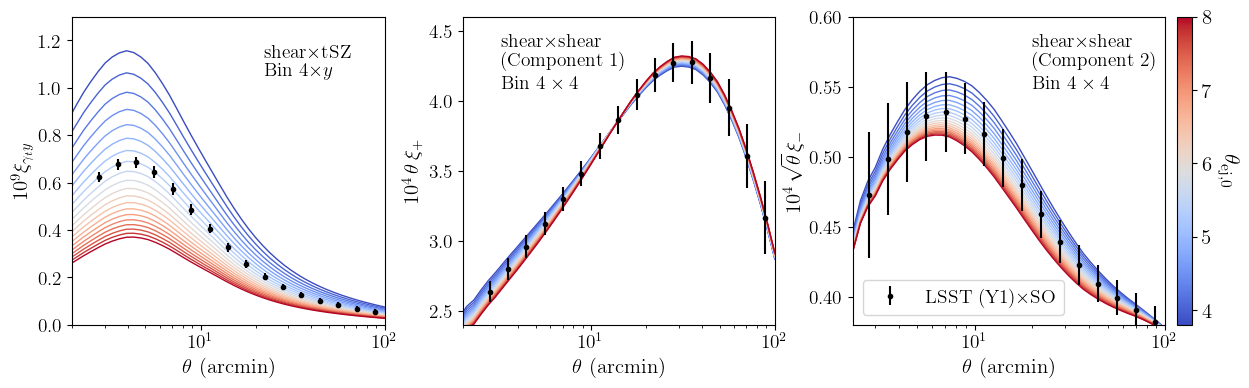

In [93]:
pl.rc('text', usetex=True)
# make a three panel plot, plotting all the theta_ej curves for for gty_out_thetaej[:,3,:], xip_out_thetaej[:,3,3,:], xim_out_thetaej[:,3,3,:]
# draw theta_ej curves from a colormap
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
norm = Normalize(vmin=(theta_ej_array).min(), vmax=(theta_ej_array).max())
analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), fac_th * len(theta_data))

pl.figure(figsize=(15,4))
# increase the distance between subplots:
pl.subplots_adjust(wspace=0.25)
pl.subplot(131)
for jM in tqdm(range(len(theta_ej_array))):
    color = cmap(norm((theta_ej_array[jM])))
    pl.plot(analysis_dict_vary['angles_data_array'], 1e9*gty_out_all[jM,:], color=color, alpha=1.0,lw=1.0)
# pl.legend()
pl.errorbar(analysis_dict['angles_data_array'], 1e9*gty_data_to_plot, yerr=1e9*gty_sig_to_plot, fmt='o', color='k',label='data', ms=3.05)
pl.text(22, 1.05, r'shear$\times$tSZ' + '\n' + r'Bin 4$\times y$', fontsize=14)
pl.xscale('log')
pl.xlim(2.0,100)
pl.ylim(0.0,1.3)
pl.ylabel(r'$10^9 \xi_{\gamma_t y}$', fontsize=15)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=15)
# set tick label sizes:
pl.tick_params(axis='both', which='major', labelsize=14)
pl.tick_params(axis='both', which='minor', labelsize=14)
# pl.title('1-halo term')
pl.subplot(132)
for jM in tqdm(range(len(theta_ej_array))):
    color = cmap(norm((theta_ej_array[jM])))
    # pl.plot(analysis_dict_vary['angles_data_array'], 1e4*xip_out_all[jM,:], color=color, alpha=1.0,lw=1.0)
    pl.plot(analysis_dict_vary['angles_data_array'], 1e4*xip_out_all[jM,:]*analysis_dict_vary['angles_data_array'], color=color, alpha=1.0,lw=1.0)    
# pl.errorbar(analysis_dict['angles_data_array'], 1e4*xip_data_to_plot, yerr=1e4*xip_sig_to_plot, fmt='o', color='k',label='data', ms=3.05)
pl.errorbar(analysis_dict['angles_data_array'], 1e4*xip_data_to_plot*analysis_dict['angles_data_array'], yerr=1e4*xip_sig_to_plot*analysis_dict['angles_data_array'], fmt='o', color='k',label='data', ms=3.05)
# pl.legend()
pl.text(3.25, 4.1, r'shear$\times$shear' + '\n' + '(Component 1)' + '\n' + r'Bin $4 \times 4$', fontsize=14)
pl.xscale('log')
# pl.yscale('log')
pl.xlim(2.0,100)
pl.ylim(2.4,4.6)
pl.ylabel(r'$10^4 \, \theta \, \xi_+$', fontsize=15)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=15)
pl.tick_params(axis='both', which='major', labelsize=14)
pl.tick_params(axis='both', which='minor', labelsize=14)
# pl.title('2-halo term')
pl.subplot(133)
for jM in tqdm(range(len(theta_ej_array))):
    color = cmap(norm((theta_ej_array[jM])))
    # pl.plot(analysis_dict_vary['angles_data_array'], 1e5*xim_out_all[jM,:], color=color, alpha=1.0,lw=1.0)
    pl.plot(analysis_dict_vary['angles_data_array'], 1e4*xim_out_all[jM,:]*np.sqrt(analysis_dict_vary['angles_data_array']), color=color, alpha=1.0,lw=1.0)    
# pl.errorbar(analysis_dict['angles_data_array'], 1e5*xim_data_to_plot, yerr=1e5*xim_sig_to_plot, fmt='o', color='k', label=r'LSST (Y1)$\times$SO', ms=3.05)
pl.errorbar(analysis_dict['angles_data_array'], 1e4*xim_data_to_plot*np.sqrt(analysis_dict['angles_data_array']), yerr=1e4*xim_sig_to_plot*np.sqrt(analysis_dict['angles_data_array']), fmt='o', color='k', label=r'LSST (Y1)$\times$SO', ms=3.05)
pl.legend(loc='lower left', fontsize=14)
# pl.legend()
pl.xscale('log')
pl.text(20, 0.55, r'shear$\times$shear' + '\n' +'(Component 2)' + '\n' + r'Bin $4 \times 4$', fontsize=14)
# pl.yscale('log')
pl.xlim(2.3,100)
pl.ylim(0.38,0.6)
pl.ylabel(r'$10^4 \, \sqrt{\theta} \, \xi_-$', fontsize=15)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=15)
# pl.title('2-halo term')
pl.tick_params(axis='both', which='major', labelsize=14)
pl.tick_params(axis='both', which='minor', labelsize=14)
# create a ScalarMappable with the colormap and norm
sm = ScalarMappable(cmap=cmap, norm=norm)
# the array is not used in this case, but normally the values used for the colormap are passed here
sm.set_array([])
# add the colorbar to the figure
cbar = pl.colorbar(sm, ax=pl.gcf().get_axes(), orientation='vertical', fraction=0.05, pad=0.01)
cbar.set_label(r'$\theta_{\rm ej, 0}$', fontsize=16, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=15)
pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/forecast_dv_lssty1_so.pdf', bbox_inches='tight')






In [37]:
import jax 
from tqdm import tqdm
import copy
from tqdm import tqdm
from get_corr_func_jit import get_corrfunc_BCMP
fac_th = 3
analysis_dict_vary = copy.deepcopy(analysis_dict)
analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), fac_th * len(theta_data))

@jax.jit
def get_mean_sims(logp):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    other_params_dict_vary = copy.deepcopy(other_params_dict)

    for jp in range(len(sim_param_vary_names)):
        sim_params_dict_vary[sim_param_vary_names[jp]] = jnp.exp(logp[jp])
    
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict_vary, other_params_dict_vary, verbose_time=False)

    mu = jnp.concatenate([get_corrfunc_BCMP_test.gty_out_mat[:,3], get_corrfunc_BCMP_test.xip_out_mat[:,3,3], get_corrfunc_BCMP_test.xim_out_mat[:,3,3]])

    return jnp.log(mu)



In [38]:
# sims_params_vary_names_all = ['theta_ej_0', 'theta_co_0','nu_z', 'nu_theta_ej_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt', 'nu_theta_ej_M']

sims_params_vary_names_all = ['theta_ej_0', 'mu_beta']


dmu_sims_all = np.zeros((180, len(sims_params_vary_names_all)))
for jp in tqdm(range(len(sims_params_vary_names_all))):
    sim_param_vary_names = [sims_params_vary_names_all[jp]]
    params_fid = jnp.log(jnp.array([sim_params_dict[sims_params_vary_names_all[jp]]]))

    jac_mean = jax.jit(jax.jacfwd(get_mean_sims))
    dmu_sim = jac_mean(params_fid)
    dmu_sims_all[:,jp] = dmu_sim[:,0]



  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:33<00:00, 16.54s/it]


In [21]:
# jac_mean = jax.jit(jax.jacfwd(get_mean_sims))
# dlogmu_logp_sim = jac_mean(jnp.log(sim_params_dict['theta_ej_0']))
# # dmu_sims_all[:,jp] = dmu_sim[:,0]




In [22]:
# # dlogmu_logp_sim.shape
# pl.figure()
# pl.plot(analysis_dict_vary['angles_data_array'],dlogmu_logp_sim[0:60])
# pl.plot(analysis_dict_vary['angles_data_array'],dlogmu_logp_sim[60:120])
# pl.plot(analysis_dict_vary['angles_data_array'],dlogmu_logp_sim[120:180])
# pl.xscale('log')



In [39]:
import jax 
from tqdm import tqdm

@jax.jit
def get_mean_cosmo(logp):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)
    other_params_dict_vary = copy.deepcopy(other_params_dict)

    for jp in range(len(cosmo_params_vary_names)):
        sim_params_dict_vary['cosmo'][cosmo_params_vary_names[jp]] = jnp.exp(logp[jp])
    
    get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict_vary, halo_params_dict, analysis_dict_vary, other_params_dict_vary, verbose_time=False)

    mu = jnp.concatenate([get_corrfunc_BCMP_test.gty_out_mat[:,3], get_corrfunc_BCMP_test.xip_out_mat[:,3,3], get_corrfunc_BCMP_test.xim_out_mat[:,3,3]])

    return jnp.log(mu)




In [40]:

# cosmo_params_vary_names_all = ['Om0', 'Ob0', 'H0', 'ns', 'sigma8']
# cosmo_params_vary_names_all = ['Om0', 'Ob0', 'sigma8']
cosmo_params_vary_names_all = ['Om0', 'sigma8']

cosmo_params_fid_all = np.zeros(len(cosmo_params_vary_names_all))
for jp in range(len(cosmo_params_vary_names_all)):
    cosmo_params_fid_all[jp] = sim_params_dict['cosmo'][cosmo_params_vary_names_all[jp]]

dmu_cosmo_all = np.zeros((180, len(cosmo_params_vary_names_all)))
for jp in tqdm(range(len(cosmo_params_vary_names_all))):
    cosmo_params_vary_names = [cosmo_params_vary_names_all[jp]]
    params_fid = jnp.log(jnp.array([sim_params_dict['cosmo'][cosmo_params_vary_names_all[jp]]]))

    jac_mean = jax.jit(jax.jacfwd(get_mean_cosmo))
    dmu_cosmo = jac_mean(params_fid)
    dmu_cosmo_all[:, jp] = dmu_cosmo[:,0]







  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [01:01<00:00, 30.86s/it]


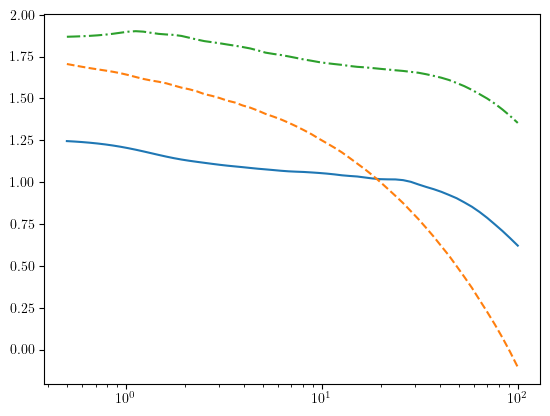

In [41]:
# dlogmu_logp_sim.shape
pl.figure()
pl.plot(analysis_dict_vary['angles_data_array'],dmu_cosmo_all[:,0][0:60], ls='-')
pl.plot(analysis_dict_vary['angles_data_array'],dmu_cosmo_all[:,0][60:120], ls='--')
pl.plot(analysis_dict_vary['angles_data_array'],dmu_cosmo_all[:,0][120:180], ls='-.')

# pl.plot(analysis_dict_vary['angles_data_array'],dmu_cosmo_all[:,1][0:60], ls='-')
# pl.plot(analysis_dict_vary['angles_data_array'],dmu_cosmo_all[:,1][60:120], ls='--')
# pl.plot(analysis_dict_vary['angles_data_array'],dmu_cosmo_all[:,1][120:180], ls='-.')

pl.xscale('log')





In [31]:
# np.abs(dmu_cosmo_all[:,0][60:120])


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

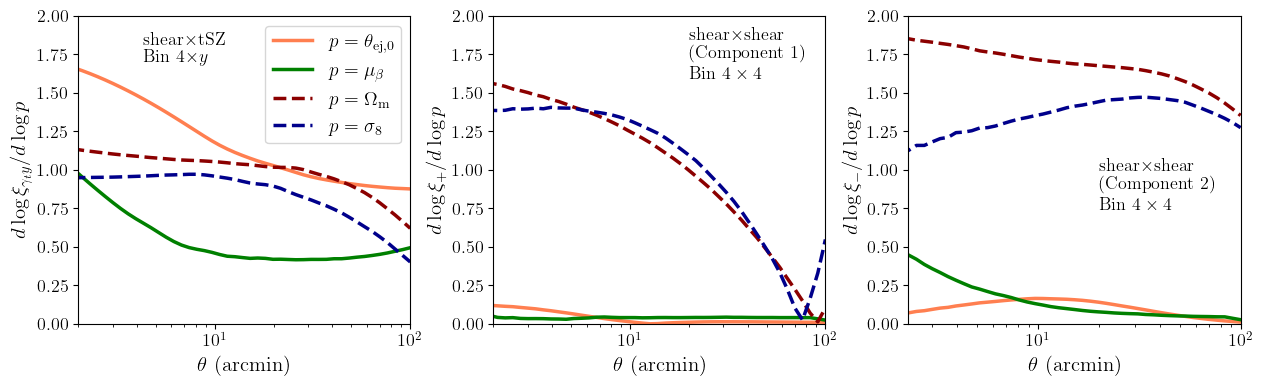

In [96]:
pl.rc('text', usetex=True)
# make a three panel plot, plotting all the theta_ej curves for for gty_out_thetaej[:,3,:], xip_out_thetaej[:,3,3,:], xim_out_thetaej[:,3,3,:]
# draw theta_ej curves from a colormap
from matplotlib import cm, colorbar
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
def moving_average(data, window_size=5):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# create a normalize object the scales the input Mc0 value to the range [0,1]
# norm = Normalize(vmin=(theta_ej_array).min(), vmax=(theta_ej_array).max())
# analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), fac_th * len(theta_data))

pl.figure(figsize=(15,4))
# increase the distance between subplots:
pl.subplots_adjust(wspace=0.25)
pl.subplot(131)
# for jM in tqdm(range(len(theta_ej_array))):
#     color = cmap(norm((theta_ej_array[jM])))
pl.plot(analysis_dict_vary['angles_data_array'], np.abs(dmu_sims_all[:,0][:60]), color='coral', alpha=1.0,lw=2.5, label=r'$p = \theta_{\rm ej,0}$')
pl.plot(analysis_dict_vary['angles_data_array'], np.abs(dmu_sims_all[:,1][:60]), color='green', alpha=1.0,lw=2.5, label=r'$p = \mu_{\beta}$')

pl.plot(analysis_dict_vary['angles_data_array'], np.abs(dmu_cosmo_all[:,0][:60]), color='darkred', alpha=1.0,lw=2.5, ls='--', label=r'$p=\Omega_{\rm m}$')
pl.plot(analysis_dict_vary['angles_data_array'], np.abs(dmu_cosmo_all[:,1][:60]), color='darkblue', alpha=1.0,lw=2.5, ls='--', label=r'$p=\sigma_8$')
pl.legend(loc='upper right', fontsize=14)

# pl.legend()
# pl.errorbar(analysis_dict['angles_data_array'], 1e9*gty_data_to_plot, yerr=1e9*gty_sig_to_plot, fmt='o', color='k',label='data', ms=3.05)
pl.text(4.3, 1.7, r'shear$\times$tSZ' + '\n' + r'Bin 4$\times y$', fontsize=13)
pl.xscale('log')
# pl.yscale('log')
pl.xlim(2.0,100)
pl.ylim(0.0,2)
pl.ylabel(r'$d\log \xi_{\gamma_t y}/d\log p$', fontsize=15)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=15)
# set tick label sizes:
pl.tick_params(axis='both', which='major', labelsize=13)
pl.tick_params(axis='both', which='minor', labelsize=13)
# pl.title('1-halo term')
pl.subplot(132)
pl.plot(analysis_dict_vary['angles_data_array'], np.abs(dmu_sims_all[:,0][60:120]), color='coral', alpha=1.0,lw=2.5, label=r'$p = \theta_{\rm ej,0}$')
pl.plot(analysis_dict_vary['angles_data_array'], moving_average(np.abs(dmu_sims_all[:,1][60:120])), color='green', alpha=1.0,lw=2.5, label=r'$p = \mu_{\beta}$')

pl.plot(analysis_dict_vary['angles_data_array'], np.abs(dmu_cosmo_all[:,0][60:120]), color='darkred', alpha=1.0,lw=2.5, ls='--', label=r'$p=\Omega_{\rm m}$')
pl.plot(analysis_dict_vary['angles_data_array'], np.abs(dmu_cosmo_all[:,1][60:120]), color='darkblue', alpha=1.0,lw=2.5, ls='--', label=r'p=$\sigma_8$')
# pl.legend(loc='upper right', fontsize=14)

# pl.legend()
pl.text(20.0, 1.6, r'shear$\times$shear' + '\n' + '(Component 1)' + '\n' + r'Bin $4 \times 4$', fontsize=13)
pl.xscale('log')
# pl.yscale('log')
# pl.yscale('log')
pl.xlim(2.0,100)
pl.ylim(0.0,2)
# pl.ylim(2.4,4.6)
# pl.ylabel(r'$10^4 \, \theta \, \xi_+$', fontsize=14)
pl.ylabel(r'$d\log \xi_{+}/d\log p$', fontsize=15)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=15)
pl.tick_params(axis='both', which='major', labelsize=13)
pl.tick_params(axis='both', which='minor', labelsize=13)
# pl.title('2-halo term')
pl.subplot(133)
pl.plot(analysis_dict_vary['angles_data_array'], np.abs(dmu_sims_all[:,0][120:]), color='coral', alpha=1.0,lw=2.5)
pl.plot(analysis_dict_vary['angles_data_array'], moving_average(np.abs(dmu_sims_all[:,1][120:])), color='green', alpha=1.0,lw=2.5)

pl.plot(analysis_dict_vary['angles_data_array'], np.abs(dmu_cosmo_all[:,0][120:]), color='darkred', alpha=1.0,lw=2.5, ls='--')
pl.plot(analysis_dict_vary['angles_data_array'], np.abs(dmu_cosmo_all[:,1][120:]), color='darkblue', alpha=1.0,lw=2.5, ls='--')


# pl.legend(loc='lower left', fontsize=14)
# pl.legend()
pl.xscale('log')
# pl.yscale('log')
pl.text(20.0, 0.75, r'shear$\times$shear' + '\n' +'(Component 2)' + '\n' + r'Bin $4 \times 4$', fontsize=13)
# pl.yscale('log')
pl.xlim(2.3,100)
pl.ylim(0.0,2)
# pl.ylim(0.38,0.6)
# pl.ylabel(r'$10^4 \, \sqrt{\theta} \, \xi_-$', fontsize=14)
pl.ylabel(r'$d\log \xi_{-}/d\log p$', fontsize=15)
pl.xlabel(r'$\theta$ (arcmin)', fontsize=15)
# pl.title('2-halo term')
pl.tick_params(axis='both', which='major', labelsize=13)
pl.tick_params(axis='both', which='minor', labelsize=13)
# create a ScalarMappable with the colormap and norm
# sm = ScalarMappable(cmap=cmap, norm=norm)
# # the array is not used in this case, but normally the values used for the colormap are passed here
# sm.set_array([])
# # add the colorbar to the figure
# cbar = pl.colorbar(sm, ax=pl.gcf().get_axes(), orientation='vertical', fraction=0.05, pad=0.01)
# cbar.set_label(r'$\theta_{\rm ej, 0}$', fontsize=16, rotation=270, labelpad=20)
# cbar.ax.tick_params(labelsize=14)
pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/dlogxi_dlogp_params.pdf', bbox_inches='tight')








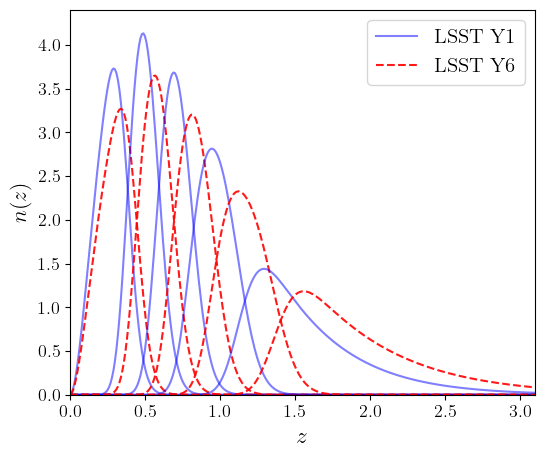

In [14]:
from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits') 
z_array = df['nz_source'].data['Z_MID']
# nz_info_dict['nbins'] = 5

df2 = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y6.fits') 
z_array2 = df2['nz_source'].data['Z_MID']
# nz_info_dict['nbins'] = 5


pl.figure(figsize=(6,5))
for jb in range(5):
    if jb==0:
        pl.plot(z_array, df['nz_source'].data['BIN%d'%(jb+1)], label='LSST Y1', color='blue', alpha=0.5)
        pl.plot(z_array2, df2['nz_source'].data['BIN%d'%(jb+1)], label='LSST Y6', color='red', alpha=0.9, ls='--')
    else:
        pl.plot(z_array, df['nz_source'].data['BIN%d'%(jb+1)], color='blue', alpha=0.5)
        pl.plot(z_array2, df2['nz_source'].data['BIN%d'%(jb+1)],  color='red', alpha=0.9, ls='--')
    
pl.legend(fontsize=15)
pl.xlabel(r'$z$', fontsize=17)
pl.ylabel(r'$n(z)$', fontsize=16)
pl.xlim(0.0,3.1)
pl.ylim(0, 4.4)
pl.tick_params(axis='both', which='major', labelsize=13)
pl.tick_params(axis='both', which='minor', labelsize=13)
pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/nz_sources.pdf', bbox_inches='tight')




In [4]:
from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/forecast/lsst_simulate_Y1.fits') 
df['nz_source'].header


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   64 / length of dimension 1                          
NAXIS2  =                  401 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
NZDATA  =                    T                                                  
EXTNAME = 'nz_source'                                                           
TTYPE1  = 'Z_LOW   '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'Z_MID   '        